# Congressional Trading Data Exploration (Fixed)

This notebook analyzes your congressional trading data with the correct column structure.

## What this notebook does:
- Loads and analyzes the `all_purchases` CSV file
- Shows data coverage by year, month, and congress member
- Analyzes stock tickers and trading volumes
- Identifies data quality issues
- Provides summary statistics for backtest planning

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("📊 Data Exploration Notebook Initialized")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

📊 Data Exploration Notebook Initialized
📅 Analysis Date: 2025-07-28 12:01:00


## 1. Load Congressional Trading Data

In [20]:
# Load the data
data_file = 'stock_purchases/all_purchases'

try:
    # Read the CSV file
    df = pd.read_csv(data_file)
    
    print(f"✅ Successfully loaded {len(df):,} records from {data_file}")
    print(f"📊 Data shape: {df.shape}")
    print(f"📋 Columns: {list(df.columns)}")
    
except FileNotFoundError:
    print(f"❌ File not found: {data_file}")
    print("Please make sure you have run the data collection scripts first.")
except Exception as e:
    print(f"❌ Error loading data: {e}")

✅ Successfully loaded 3,809 records from stock_purchases/all_purchases
📊 Data shape: (3809, 10)
📋 Columns: ['representative_name', 'stock_name', 'buy_sell_flag', 'purchase_date', 'notification_date', 'invested_amount', 'min_amount', 'max_amount', 'transaction_year', 'ticker']


## 2. Basic Data Overview

In [21]:
# Display basic info about the dataset
print("📋 DATASET OVERVIEW")
print("=" * 50)
print(f"Total Records: {len(df):,}")
print(f"Columns: {list(df.columns)}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n📊 FIRST 10 RECORDS:")
print("=" * 50)
display(df.head(10))

print("\n📊 DATA TYPES:")
print("=" * 50)
print(df.dtypes)

print("\n📊 MISSING VALUES:")
print("=" * 50)
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
})
print(missing_summary[missing_summary['Missing Count'] > 0])

📋 DATASET OVERVIEW
Total Records: 3,809
Columns: ['representative_name', 'stock_name', 'buy_sell_flag', 'purchase_date', 'notification_date', 'invested_amount', 'min_amount', 'max_amount', 'transaction_year', 'ticker']
Memory Usage: 1.86 MB

📊 FIRST 10 RECORDS:


,representative_name,stock_name,buy_sell_flag,purchase_date,notification_date,invested_amount,min_amount,max_amount,transaction_year,ticker
0,AllenRichard W.,"Rollins, Inc. Common Stock (ROL)",P,2024-12-12,01/08/2025,"$15,001 - \$50000",15001.0,50000.0,2024.0,NaN
1,AllenRichard W.,US TREASU NOTE 4.375% DUE,P,2024-12-03,01/08/2025,"\$100,001 -\$250,000",100001.0,250000.0,2024.0,NaN
2,AllenRichard W.,US TREASURY BILL DUE 03/20/25,P,2024-12-03,01/08/2024,"$15,001 - \$9127975500001",15001.0,50000.0,2024.0,NaN
3,AllenRichard W.,US TREASURY NOTE 4.25% DUE,P,2024-12-03,01/08/2024,"\$50,001 -\$100,000",50001.0,100000.0,2024.0,NaN
4,AllenRichard W.,"AutoZone, Inc. Common Stock (AZO)",P,2025-01-17,02/04/2025,"$15,001 - \$50000",15001.0,50000.0,2025.0,AZO
5,AllenRichard W.,US Treasury Bill 912797JR9 [GS],S (partial),2025-01-08,02/04/2025,"\$15,001 -\$50,000",15001.0,50000.0,2025.0,out of scope
6,AllenRichard W.,US Treasury Bill 912797JR9 [GS],S (partial),2025-01-08,02/04/2025,"$15,001 - \$500001",15001.0,50000.0,2025.0,out of scope
7,AllenRichard W.,US Treasury Bill 91282CHB0 [GS],P,2025-01-27,02/04/2025,"\$100,001 -\$250,000",100001.0,250000.0,2025.0,out of scope
8,AllenRichard W.,US Treasury Bill 91282CKE0 [GS],P,2025-01-27,02/04/2025,"$100,001 - \$2500001",100001.0,250000.0,2025.0,out of scope
9,AllenRichard W.,US Treasury Bill - Due 12/15/26,P,2025-02-26,03/05/2025,"$50,001 - \$4375",50001.0,100000.0,2025.0,out of scope



📊 DATA TYPES:
representative_name     object
stock_name              object
buy_sell_flag           object
purchase_date           object
notification_date       object
invested_amount         object
min_amount             float64
max_amount             float64
transaction_year       float64
ticker                  object
dtype: object

📊 MISSING VALUES:
            Missing Count  Missing %
min_amount              9   0.236282
max_amount              9   0.236282
ticker                279   7.324757


## 3. Date Processing and Analysis

In [22]:
# Convert date columns to datetime
print("🗓️ PROCESSING DATES...")

# Function to safely convert dates
def safe_date_convert(date_series, column_name):
    try:
        converted = pd.to_datetime(date_series, errors='coerce')
        invalid_count = converted.isnull().sum()
        if invalid_count > 0:
            print(f"⚠️ {invalid_count} invalid dates in {column_name}")
        return converted
    except Exception as e:
        print(f"❌ Error converting {column_name}: {e}")
        return date_series

# Convert dates - adjust column names based on actual data
if 'purchase_date' in df.columns:
    df['purchase_date'] = safe_date_convert(df['purchase_date'], 'purchase_date')
    date_col = 'purchase_date'
elif 'transaction_date' in df.columns:
    df['transaction_date'] = safe_date_convert(df['transaction_date'], 'transaction_date')
    date_col = 'transaction_date'
else:
    print("❌ No recognized date column found")
    date_col = None

if 'notification_date' in df.columns:
    df['notification_date'] = safe_date_convert(df['notification_date'], 'notification_date')
elif 'disclosure_date' in df.columns:
    df['disclosure_date'] = safe_date_convert(df['disclosure_date'], 'disclosure_date')

# Extract year, month for analysis
if date_col:
    df['transaction_year'] = df[date_col].dt.year
    df['transaction_month'] = df[date_col].dt.month
    
    print("✅ Date processing complete")
    
    # Date range summary
    valid_transactions = df.dropna(subset=[date_col])
    if len(valid_transactions) > 0:
        print(f"\n📅 TRANSACTION DATE RANGE:")
        print(f"Earliest: {valid_transactions[date_col].min()}")
        print(f"Latest: {valid_transactions[date_col].max()}")
        print(f"Span: {(valid_transactions[date_col].max() - valid_transactions[date_col].min()).days} days")
else:
    print("⚠️ Skipping date analysis - no valid date column found")

🗓️ PROCESSING DATES...
✅ Date processing complete

📅 TRANSACTION DATE RANGE:
Earliest: 2015-05-08 00:00:00
Latest: 2025-07-15 00:00:00
Span: 3721 days


## 4. Data Coverage by Year

📊 DATA COVERAGE BY YEAR
                  total_transactions  unique_tickers  total_min_amount  \
transaction_year                                                         
2015                               2               2           30002.0   
2024                             179              86        16515177.0   
2025                            3628             677        74226621.0   

                  total_max_amount  unique_members  
transaction_year                                    
2015                      100000.0               1  
2024                    68175000.0              25  
2025                   245995000.0              72  


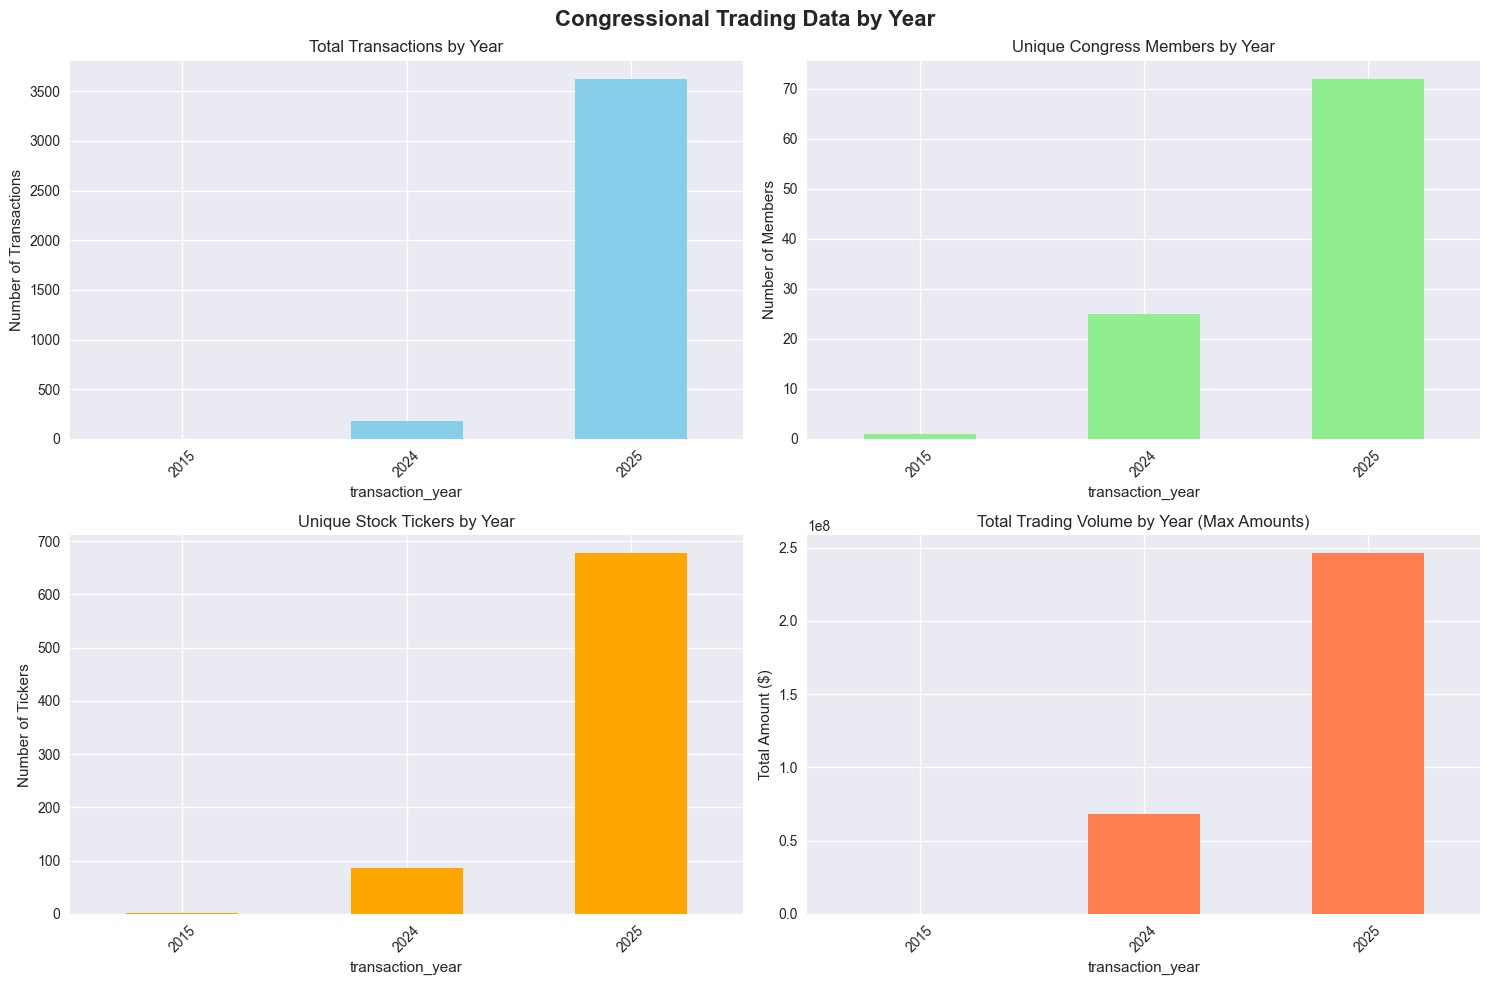

In [23]:
# Analyze data by year
print("📊 DATA COVERAGE BY YEAR")
print("=" * 50)

if 'transaction_year' in df.columns:
    # Convert amount columns to numeric
    amount_min_col = 'min_amount' if 'min_amount' in df.columns else 'amount_min'
    amount_max_col = 'max_amount' if 'max_amount' in df.columns else 'amount_max'
    
    df[amount_min_col] = pd.to_numeric(df[amount_min_col], errors='coerce')
    df[amount_max_col] = pd.to_numeric(df[amount_max_col], errors='coerce')
    
    # Transaction year analysis
    year_summary = df.groupby('transaction_year').agg({
        'representative_name': 'count',
        'ticker': lambda x: x[x != 'out of scope'].nunique(),
        amount_min_col: 'sum',
        amount_max_col: 'sum'
    }).rename(columns={
        'representative_name': 'total_transactions',
        'ticker': 'unique_tickers',
        amount_min_col: 'total_min_amount',
        amount_max_col: 'total_max_amount'
    })
    
    # Add unique members per year
    year_summary['unique_members'] = df.groupby('transaction_year')['representative_name'].nunique()
    
    # Remove rows with NaN years (invalid dates)
    year_summary = year_summary.dropna()
    
    print(year_summary)
    
    # Plot yearly distribution only if we have valid data
    if len(year_summary) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Congressional Trading Data by Year', fontsize=16, fontweight='bold')
        
        # Transactions per year
        year_summary['total_transactions'].plot(kind='bar', ax=axes[0,0], color='skyblue')
        axes[0,0].set_title('Total Transactions by Year')
        axes[0,0].set_ylabel('Number of Transactions')
        axes[0,0].tick_params(axis='x', rotation=45)
        
        # Unique members per year
        year_summary['unique_members'].plot(kind='bar', ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title('Unique Congress Members by Year')
        axes[0,1].set_ylabel('Number of Members')
        axes[0,1].tick_params(axis='x', rotation=45)
        
        # Unique tickers per year
        year_summary['unique_tickers'].plot(kind='bar', ax=axes[1,0], color='orange')
        axes[1,0].set_title('Unique Stock Tickers by Year')
        axes[1,0].set_ylabel('Number of Tickers')
        axes[1,0].tick_params(axis='x', rotation=45)
        
        # Total trading volume (using max amounts) - only if we have valid amounts
        if year_summary['total_max_amount'].sum() > 0:
            year_summary['total_max_amount'].plot(kind='bar', ax=axes[1,1], color='coral')
            axes[1,1].set_title('Total Trading Volume by Year (Max Amounts)')
            axes[1,1].set_ylabel('Total Amount ($)')
            axes[1,1].tick_params(axis='x', rotation=45)
        else:
            axes[1,1].text(0.5, 0.5, 'No valid amount data', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Total Trading Volume by Year')
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ No valid yearly data to plot")
else:
    print("⚠️ No transaction year data available for analysis")

## 5. Congress Members Analysis

👥 CONGRESS MEMBERS ANALYSIS
📊 Using member column: representative_name
📊 Using amount column: max_amount
📊 Using date column: purchase_date

📊 TOTAL UNIQUE MEMBERS: 73

🏆 TOP 10 MOST ACTIVE MEMBERS:
                       unique_tickers  total_volume  total_transactions  \
representative_name                                                       
BresnahanRob                      290    12590000.0                 627   
ShreveJefferson                   237    44880000.0                 618   
GottheimerJosh                    167    73510000.0                 404   
JohnsonJulie                      179     4310000.0                 271   
CisnerosGilbert                   135    11350000.0                 249   
GreeneMarjorie Taylor              74     5795000.0                 228   
WestermanBruce                     97     3475000.0                 213   
MooreTim                           13    13645000.0                 119   
DelaneyApril McClain               29     1625000.0

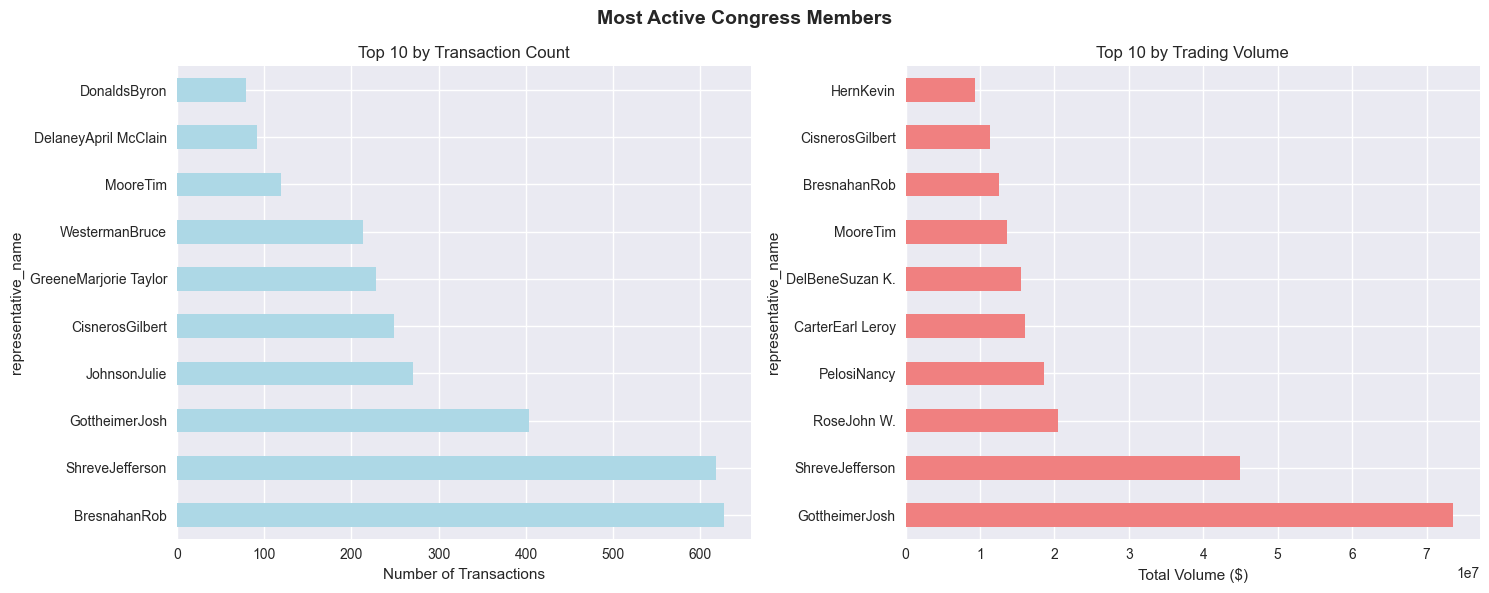

In [26]:
# Analyze congress members
print("👥 CONGRESS MEMBERS ANALYSIS")
print("=" * 50)

# Use the correct column names
member_col = 'representative_name' if 'representative_name' in df.columns else 'member'
amount_max_col = 'max_amount' if 'max_amount' in df.columns else 'amount_max'

# Check what columns we have for date analysis
date_col = None
if 'purchase_date' in df.columns:
    date_col = 'purchase_date'
elif 'transaction_date' in df.columns:
    date_col = 'transaction_date'
elif 'date' in df.columns:
    date_col = 'date'

print(f"📊 Using member column: {member_col}")
print(f"📊 Using amount column: {amount_max_col}")
print(f"📊 Using date column: {date_col if date_col else 'None - using member count'}")

# Most active members - Fixed aggregation dictionary
agg_dict = {
    'ticker': lambda x: x[x != 'out of scope'].nunique(),
    amount_max_col: 'sum'
}

# Add date or member count (fixed the syntax error)
if date_col and date_col in df.columns:
    agg_dict[date_col] = 'count'
    count_col = date_col
else:
    agg_dict[member_col] = 'count'
    count_col = member_col

# Add transaction year if available
if 'transaction_year' in df.columns:
    agg_dict['transaction_year'] = lambda x: x.nunique()

member_activity = df.groupby(member_col).agg(agg_dict)

# Rename columns properly
rename_dict = {
    'ticker': 'unique_tickers',
    amount_max_col: 'total_volume'
}

if date_col and date_col in df.columns:
    rename_dict[date_col] = 'total_transactions'
else:
    rename_dict[member_col] = 'total_transactions'

if 'transaction_year' in df.columns:
    rename_dict['transaction_year'] = 'years_active'

member_activity = member_activity.rename(columns=rename_dict)
member_activity = member_activity.sort_values('total_transactions', ascending=False)

print(f"\n📊 TOTAL UNIQUE MEMBERS: {len(member_activity)}")
print(f"\n🏆 TOP 10 MOST ACTIVE MEMBERS:")
print(member_activity.head(10))

# Plot top members
if len(member_activity) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Most Active Congress Members', fontsize=14, fontweight='bold')
    
    # Top 10 by transaction count
    top_members = member_activity.head(10)
    top_members['total_transactions'].plot(kind='barh', ax=axes[0], color='lightblue')
    axes[0].set_title('Top 10 by Transaction Count')
    axes[0].set_xlabel('Number of Transactions')
    
    # Top 10 by trading volume (if we have valid volume data)
    if 'total_volume' in member_activity.columns and member_activity['total_volume'].sum() > 0:
        top_volume = member_activity.sort_values('total_volume', ascending=False).head(10)
        top_volume['total_volume'].plot(kind='barh', ax=axes[1], color='lightcoral')
        axes[1].set_title('Top 10 by Trading Volume')
        axes[1].set_xlabel('Total Volume ($)')
    else:
        axes[1].text(0.5, 0.5, 'No valid volume data', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Top 10 by Trading Volume')
    
    plt.tight_layout()
    plt.show()

## 6. Stock Tickers Analysis

📈 STOCK TICKERS ANALYSIS
Total stock transactions: 3,606
Out of scope transactions: 203
Empty/null ticker transactions: 279

📊 TOTAL UNIQUE TICKERS: 677

🏆 TOP 15 MOST TRADED STOCKS:
        total_transactions  unique_members  total_volume  purchases  sales
ticker                                                                    
MSFT                    63              17    72335000.0       14.0   10.0
NVDA                    52              13     8950000.0       14.0    4.0
AMZN                    39              18     1815000.0       10.0    2.0
TSLA                    38               8      840000.0        9.0    5.0
GOOG                    36              17     7155000.0        6.0    8.0
AVGO                    34              14     6105000.0        8.0    2.0
AAPL                    33              13     2465000.0        6.0    6.0
V                       33              13      940000.0        9.0    2.0
META                    31               9     1075000.0        9.0

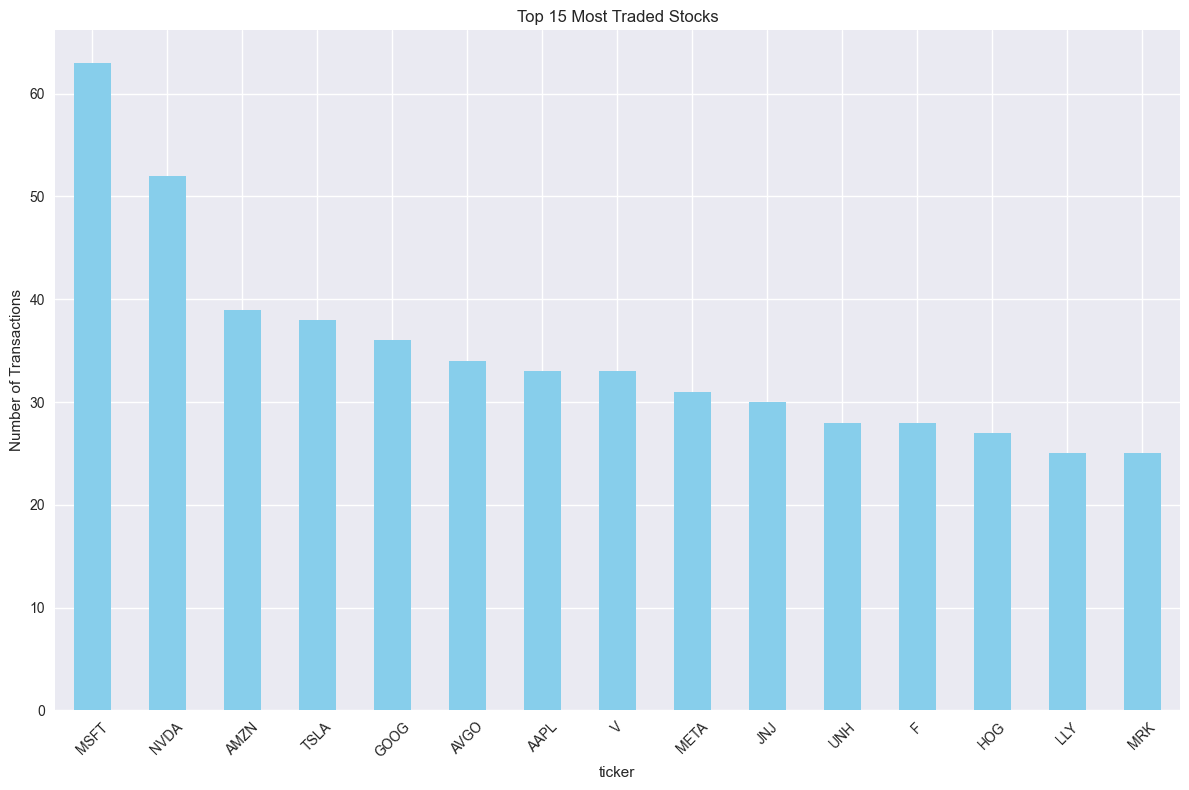

In [27]:
# Analyze stock tickers
print("📈 STOCK TICKERS ANALYSIS")
print("=" * 50)

# Filter out 'out of scope' entries
stock_data = df[df['ticker'] != 'out of scope'].copy()
empty_ticker = df[df['ticker'].isnull() | (df['ticker'] == '')].copy()

print(f"Total stock transactions: {len(stock_data):,}")
print(f"Out of scope transactions: {len(df[df['ticker'] == 'out of scope']):,}")
print(f"Empty/null ticker transactions: {len(empty_ticker):,}")

if len(stock_data) > 0:
    # Most traded stocks
    ticker_summary = stock_data.groupby('ticker').agg({
        date_col if date_col else member_col: 'count',
        member_col: 'nunique',
        amount_max_col: 'sum'
    }).rename(columns={
        date_col if date_col else member_col: 'total_transactions',
        member_col: 'unique_members',
        amount_max_col: 'total_volume'
    })
    
    # Add buy/sell counts if we have transaction type data
    if 'buy_sell_flag' in stock_data.columns:
        ticker_summary['purchases'] = stock_data[stock_data['buy_sell_flag'] == 'P'].groupby('ticker').size()
        ticker_summary['sales'] = stock_data[stock_data['buy_sell_flag'] == 'S'].groupby('ticker').size()
    elif 'transaction_type' in stock_data.columns:
        ticker_summary['purchases'] = stock_data[stock_data['transaction_type'] == 'P'].groupby('ticker').size()
        ticker_summary['sales'] = stock_data[stock_data['transaction_type'] == 'S'].groupby('ticker').size()
    
    ticker_summary = ticker_summary.fillna(0)
    ticker_summary = ticker_summary.sort_values('total_transactions', ascending=False)
    
    print(f"\n📊 TOTAL UNIQUE TICKERS: {len(ticker_summary)}")
    print(f"\n🏆 TOP 15 MOST TRADED STOCKS:")
    print(ticker_summary.head(15))
    
    # Simple bar chart for top stocks
    if len(ticker_summary) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        top_15_stocks = ticker_summary.head(15)
        top_15_stocks['total_transactions'].plot(kind='bar', ax=ax, color='skyblue')
        ax.set_title('Top 15 Most Traded Stocks')
        ax.set_ylabel('Number of Transactions')
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()
else:
    print("⚠️ No valid stock ticker data found")

## 7. Final Summary for Backtesting

In [28]:
# Final summary for backtest readiness
print("🎯 BACKTEST READINESS SUMMARY")
print("=" * 50)

# Key metrics for backtesting
valid_stock_data = df[(df['ticker'] != 'out of scope') & 
                     (df['ticker'].notna()) & 
                     (df['ticker'] != '')]

if date_col:
    valid_stock_data = valid_stock_data[valid_stock_data[date_col].notna()]

print(f"\n📊 BACKTEST-READY DATA:")
print(f"Total usable transactions: {len(valid_stock_data):,}")

if date_col and len(valid_stock_data) > 0:
    print(f"Date range: {valid_stock_data[date_col].min()} to {valid_stock_data[date_col].max()}")
    
    # Show data coverage by year for backtest planning
    if 'transaction_year' in valid_stock_data.columns:
        yearly_coverage = valid_stock_data.groupby('transaction_year').agg({
            'ticker': 'nunique',
            date_col: 'count'
        }).rename(columns={'ticker': 'unique_stocks', date_col: 'transactions'})
        
        print(f"\n📅 YEARLY DATA COVERAGE:")
        print(yearly_coverage)
        
        # Recommended backtest parameters
        earliest_date = valid_stock_data[date_col].min()
        latest_date = valid_stock_data[date_col].max()
        
        print(f"\n🎯 RECOMMENDED BACKTEST SETTINGS:")
        print(f"Start Date: {earliest_date.strftime('%Y-%m-%d')}")
        print(f"End Date: {latest_date.strftime('%Y-%m-%d')}")
        print(f"Rebalancing: Weekly (Fridays)")
        print(f"Initial Capital: $100,000")

print(f"Unique stocks: {valid_stock_data['ticker'].nunique()}")
print(f"Unique members: {valid_stock_data[member_col].nunique()}")

# Check if we have amount data
if amount_max_col in valid_stock_data.columns:
    valid_amounts = valid_stock_data[valid_stock_data[amount_max_col].notna()]
    if len(valid_amounts) > 0:
        print(f"Total volume: ${valid_amounts[amount_max_col].sum():,.2f}")
    else:
        print("No valid volume data available")

print(f"\n✅ Data exploration complete! You can now run your main backtest notebook.")
print(f"\n💡 TIP: Use the date range and stock count above to set appropriate parameters in your backtest.")

🎯 BACKTEST READINESS SUMMARY

📊 BACKTEST-READY DATA:
Total usable transactions: 3,327
Date range: 2015-05-08 00:00:00 to 2025-07-15 00:00:00

📅 YEARLY DATA COVERAGE:
                  unique_stocks  transactions
transaction_year                             
2015                          2             2
2024                         86           126
2025                        677          3199

🎯 RECOMMENDED BACKTEST SETTINGS:
Start Date: 2015-05-08
End Date: 2025-07-15
Rebalancing: Weekly (Fridays)
Initial Capital: $100,000
Unique stocks: 677
Unique members: 56
Total volume: $202,625,000.00

✅ Data exploration complete! You can now run your main backtest notebook.

💡 TIP: Use the date range and stock count above to set appropriate parameters in your backtest.
